# Сравнение рынков недвижимости Питера и Москвы (Парсер Авито)

Целью данной работы явлется демонстрация работы парсера и разведовательный анализ рыков недвижимости двух городах - Санкт-Петербург и Москва - с наиболее динамично развивающимся строительным сектором. Для сбора данных мною был написан парсер для крупнейшей в россии доски объявлений - Авито. Сбор данных проходил в разделах посвященных продаже объектов недвижимости. 

In [3]:
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
import unicodedata
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Парсер 

Создаю датафрейм в который будут собираться данные

In [ ]:
realty_data = pd.DataFrame(columns=['metro', 'metro_dist', 'type', 'area', 'floor', 'storeys', 'price', 'price_per_sqm', 'address', 'development', 'datetime', 'sourсe', 'city'])

Сохраняю ссылку на страницу для нужного города: СПб или Мск

In [120]:
URL = 'https://www.avito.ru/moskva/kvartiry/prodam-ASgBAgICAUSSA8YQ'

In [4]:
URL = 'https://www.avito.ru/sankt-peterburg/kvartiry/prodam-ASgBAgICAUSSA8YQ'

**Парсер.** <br>
_Настройка_: <br>
Основные изменяемые параметры: first - первая страница сайта; pages - последняя страница сайта; city - в "Петербурге" или "Москве" В зависимости от того, какая ссылка сохранена в переменную URL <br>
_Специфика_: <br>
Парсер собирает данные из главного блока div - "description item_table-description". Внутри него содержатся подблоки самих объявлений. Каждый подблок содержит релевантную информацию, которая разбирается по составляющим, преобразовывается и записывается в таблицу. Если нужных данных для ячейки таблицы не обнаруживается в объявлении, то записывается обозначение "NA"

In [235]:
first = 151
pages = 152

for i in range(first, pages):

    PARAM = {"page": i}
    req = requests.get(url = URL, params = PARAM)
    soup = BeautifulSoup(req.text, 'lxml')

    item = []
    price = []
    metro = []
    metro_dist = []
    address = []
    sourсe = 'Авито'
#    city = soup.find('h1',attrs={"class": "page-title-text-WxwN3 page-title-inline-2v2CW"}).text
#    city = unicodedata.normalize("NFKD", city)
#    city = re.search('\w+$', city).group()
    city = 'Москве'
        
    source_div = soup.find_all('div',attrs={"class": "description item_table-description"})

    for div_i in source_div:
        
        if div_i.find('div',attrs={"data-marker": "item-development-name"}):
            development = div_i.find('div',attrs={"data-marker": "item-development-name"}).text.strip('\n ')
        else: development = 'NA'
        
        if div_i.find('h3',attrs={"class": "snippet-title"}):
            item = div_i.find('h3',attrs={"class": "snippet-title"}).text.strip(' \n')
            item = re.sub(' м²', '', item)
            item = re.sub(' эт.', '', item)
            item = re.sub('/', ', ', item)
            item = re.split(', ', item)
        else: item = ['NA','NA','NA','NA']
        
        if div_i.find('span',attrs={"class": "snippet-price"}):
            price = div_i.find('span',attrs={"class": "snippet-price"}).text.strip('\n ')
            price = re.sub('  ₽', '', price)
            price = re.sub(' ', '', price)
            price = re.sub('\nвмесяц', '', price)
        else: price = 'NA'
            
        if div_i.find('span',attrs={"class": "item-address-georeferences-item__content"}):
            metro = div_i.find('span',attrs={"class": "item-address-georeferences-item__content"}).text
        else: metro = 'NA'
        
        if div_i.find('span',attrs={"class": "item-address-georeferences-item__after"}):
            metro_dist = div_i.find('span',attrs={"class": "item-address-georeferences-item__after"}).text
            metro_dist = unicodedata.normalize("NFKD", metro_dist)
            metro_dist = re.sub(' км', '', metro_dist)
            metro_dist = re.sub(' м', '', metro_dist)
            metro_dist = re.sub(' ', '', metro_dist)
            metro_dist = re.sub(',', '.', metro_dist)
            if int(float(metro_dist)) < 50: metro_dist = float(metro_dist)*1000            
        else: metro_dist = 'NA'
        
        if div_i.find('span',attrs={"class": "item-address__string"}):
            address = div_i.find('span',attrs={"class": "item-address__string"}).text.strip('\n ')
        else: address = 'NA'

        realty_data = realty_data.append({
                        'metro': metro, 
                        'metro_dist': metro_dist, 
                        'datetime':datetime.now(),
                        'type':item[0],
                        'area':item[1],
                        'floor':item[2],
                        'storeys':item[3], 
                        'address': address,
                        'price': price,
                        'development': development,
                        'sourсe': sourсe,
                        'city': city}, 
                       ignore_index=True)
        

realty_data = realty_data.drop_duplicates(subset=realty_data.columns.difference(['datetime']))
realty_data['price_per_sqm'] = realty_data['price'].astype('int64') / realty_data['area'].astype('float64')
realty_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31824 entries, 0 to 31823
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   metro          31032 non-null  object        
 1   metro_dist     26568 non-null  object        
 2   type           31824 non-null  object        
 3   area           31824 non-null  object        
 4   floor          31824 non-null  object        
 5   storeys        31824 non-null  object        
 6   price          31824 non-null  object        
 7   address        31016 non-null  object        
 8   development    11011 non-null  object        
 9   datetime       31824 non-null  datetime64[ns]
 10  city           31824 non-null  object        
 11  sourсe         31824 non-null  object        
 12  price_per_sqm  31824 non-null  float64       
 13  new_house      31774 non-null  float64       
 14  month          31774 non-null  float64       
 15  period         3177

In [242]:
realty_data.tail()

,metro,metro_dist,type,area,floor,storeys,price,address,development,datetime,city,sourсe,price_per_sqm,new_house,month,period
31819,Крылатское,2400.0,1-к квартира,59.0,6,23,11188800,"Рублёвское ш., 70к7",NaN,2020-08-19 20:12:56.384328,Москве,Авито,189640.677966,NaN,NaN,NaN
31820,Прокшино,900.0,3-к квартира,61.1,13,18,9937178,"д. Николо-Хованское, стр. 2","ЖР «Прокшино», 3 кв. 2022 года",2020-08-19 20:12:56.408264,Москве,Авито,162637.937807,NaN,NaN,NaN
31821,Новохохловская,800.0,Студия,21.7,18,24,5034400,"1-й Грайвороновский пр-д, вл. 3, стр. 1",ЖК «Волжский парк»,2020-08-19 20:12:56.430205,Москве,Авито,232000.000000,NaN,NaN,NaN
31822,Прокшино,900.0,1-к квартира,37.7,17,18,7377382,"д. Николо-Хованское, стр. 2","ЖР «Прокшино», 3 кв. 2022 года",2020-08-19 20:12:56.453142,Москве,Авито,195686.525199,NaN,NaN,NaN
31823,Прокшино,800.0,1-к квартира,37.7,17,18,7566874,"д. Николо-Хованское, стр. 2",ЖР «Прокшино»,2020-08-19 20:12:56.475086,Москве,Авито,200712.838196,NaN,NaN,NaN


Если все хорошо, то сохраняем данные.

In [238]:
# save data
realty_data.to_csv(r'C:\Users\nikita\Documents\Yandex_Practicum_DataScience\datasets\realty_data.csv', index = False)

Загружаем снова, так данные автоматически получат адекватные типы.

In [253]:
realty_data = pd.read_csv('C:/Users/nikita/Documents/Yandex_Practicum_DataScience/datasets/realty_data.csv')
#realty_data

## Предобработка данных

Создаем булевую переменную, в которой 1 означает, что дом новый (новостройка), а 0 - относится к старому фонду.

In [254]:
realty_data['new_house'] = realty_data['development'].notna().astype(int)
realty_data['new_house'].value_counts()

0    20843
1    10981
Name: new_house, dtype: int64

Преобрзовываем переменную для даты и времени

In [256]:
realty_data['datetime'] = pd.to_datetime(realty_data['datetime'], format='%Y-%m-%dT%H:%M:%S')

Смотрим распределение цены на гистрограмме. Я обрезал хвост, поставив фильтр до 100 млн. рублей

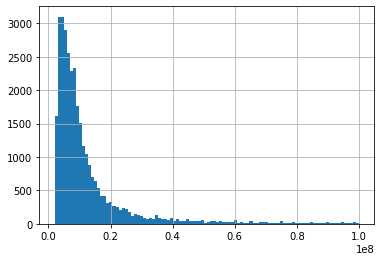

In [257]:
realty_data[realty_data['price'] < 100000000]['price'].hist(bins=100)

Смотрим скольно неадекватно дешевых квартир - до 2 млн. руб.

In [258]:
realty_data[realty_data['price'] < 2000000]['price'].count()

0

Срезаем выбросы после 100 млн. руб. и до 2 млн. руб. за квартиру

In [259]:
realty_data = realty_data[realty_data['price'] < 100000000]
realty_data = realty_data[realty_data['price'] > 2000000]

Создаем новую переменную для двух периодов. Период 1 относится к июню 2020 года, а период 2 к августу 2020. Далее буду сравнивать данные по двум периодам и двум городам

In [260]:
realty_data['month'] = realty_data['datetime'].dt.month
realty_data.loc[realty_data['month'] == 8, 'period'] = 2
realty_data.loc[realty_data['month'] != 8, 'period'] = 1

В данных были обнаружена ошибка. Некоторые квартиры из СПб были отмечены как из Мск. Я создал список районов и метро относящихся к Питеру и отфильтровав по нему данные, заменил все отместки "Москве" на "Петербурге". 

In [261]:
spb_districts = realty_data[realty_data['period'] == 1][realty_data['city'] == 'Петербурге']['metro'].value_counts().reset_index()['index'].tolist()
realty_data['city'][realty_data['metro'].isin(spb_districts)==True] = 'Петербурге'

## Исследуем данные 

### Смотрим статистики по ценам

In [262]:
# price desctibe
realty_data['price'].describe()

count    3.182100e+04
mean     1.234302e+07
std      1.372550e+07
min      2.001520e+06
25%      4.980000e+06
50%      8.000000e+06
75%      1.330000e+07
max      9.999990e+07
Name: price, dtype: float64

Строим сводную таблицу. В ней я сравниваю статистики: минимальная, средняя и медианная цена для Москвы и Питера для квартир с разным количеством комнат в т.ч. студии и квартиры свободной планировки.

In [263]:
realty_data.pivot_table(index=['type'], columns='city', values=['price','area'], aggfunc=['min', 'mean', 'median'])

min                                           mean  \
                   area                  price                    area   
city             Москве Петербурге      Москве  Петербурге      Москве   
type                                                                     
1-к квартира       12.3       12.4   2020912.0   2001520.0   38.829785   
2-к квартира       27.0       26.0   2500000.0   2100000.0   59.066615   
3-к квартира       41.0       41.0   3150000.0   2300000.0   84.709707   
4-к квартира       62.7       48.0   5500000.0   3790000.0  120.679705   
5-к квартира       48.0       67.0   2600000.0   6500000.0  172.542331   
6-к квартира      135.1      104.6  14900000.0  12600000.0  237.640625   
7-к квартира      122.2       80.9  14925000.0   8900000.0  235.620000   
8-к квартира      186.7      194.0  17226073.0  16800000.0  208.300000   
9-к квартира      165.0        NaN  38890000.0         NaN  261.500000   
> 9-к квартира    181.2      182.0  64000000.0  12900000.0  373.866667   
Своб. планировка   18.0       27.2   3132000.0   2950000.0   82.066667   
Студия             10.0       10.0   2040000.0   2003000.0   21.762367   

                                                         median             \
                                     price                 area              
city              Петербурге        Москве    Петербурге Москве Петербурге   
type                                                                         
1-к квартира       38.569575  8.801927e+06  5.762732e+06   38.0      37.70   
2-к квартира       60.299741  1.400865e+07  1.007958e+07   57.0      57.60   
3-к квартира       89.294831  2.078331e+07  1.703006e+07   80.0      83.00   
4-к квартира      125.837277  3.310163e+07  2.810580e+07  113.4     119.90   
5-к квартира      164.672059  5.471395e+07  3.392975e+07  167.1     150.00   
6-к квартира      189.375926  6.141733e+07  3.935651e+07  225.9     181.40   
7-к квартира      192.680000  4.542500e+07  2.863688e+07  260.0     181.55   
8-к квартира      263.021429  6.504202e+07  3.566957e+07  187.0     256.50   
9-к квартира             NaN  4.694500e+07           NaN  261.5        NaN   
> 9-к квартира    314.940000  8.459233e+07  4.195020e+07  341.9     300.00   
Своб. планировка   90.846296  2.435615e+07  1.589575e+07   77.4      81.60   
Студия             24.497175  4.873481e+06  3.628172e+06   19.9      25.00   

                                          
                       price              
city                  Москве  Петербурге  
type                                      
1-к квартира       7500000.0   4890000.0  
2-к квартира      10627482.0   7605274.0  
3-к квартира      15500000.0  11500000.0  
4-к квартира      25293444.0  19900000.0  
5-к квартира      55000000.0  22700000.0  
6-к квартира      64850000.0  30400000.0  
7-к квартира      32000000.0  18250000.0  
8-к квартира      79900000.0  29950000.0  
9-к квартира      46945000.0         NaN  
> 9-к квартира    90000000.0  41226000.0  
Своб. планировка  19700000.0  12232500.0  
Студия             4100000.0   3300000.0

### Исследуем соотношение данных в датасете

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

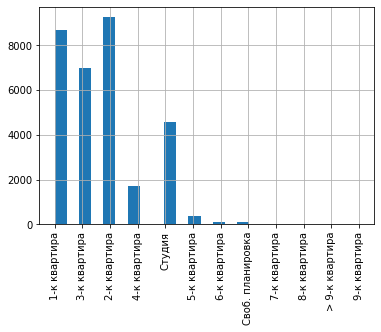

In [264]:
realty_data['type'].hist(bins=25)
plt.xticks(rotation=90)

Количество квартир по типам в данных. В дальнейшем работаем только с квартирами 1, 2, 3, 4, 5 комнатными и студиями. Остальных слишком мало для анализа. 

### Соотношение квартир в СПб и Мск в период 1 и 2

([0, 1], <a list of 2 Text xticklabel objects>)

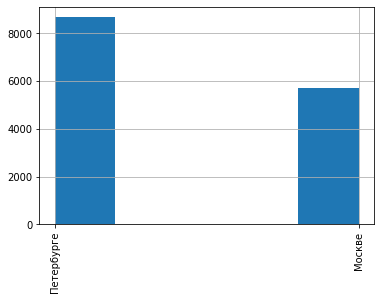

In [265]:
realty_data[realty_data['period'] == 1]['city'].hist(bins=5)
plt.xticks(rotation=90)

([0, 1], <a list of 2 Text xticklabel objects>)

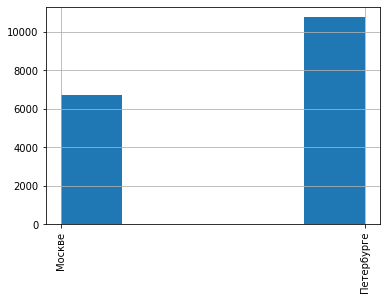

In [266]:
realty_data[realty_data['period'] == 2]['city'].hist(bins=5)
plt.xticks(rotation=90) 

Для Москвы спарсено немного меньше квартир

### Новостройки и старый фонд

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

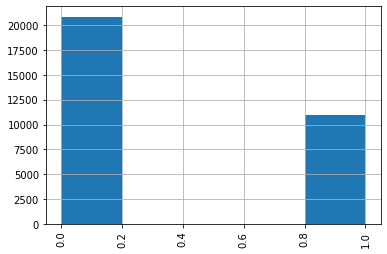

In [267]:
realty_data['new_house'].hist(bins=5)
plt.xticks(rotation=90)

Новостроек меньше в два раза, по отношению к старому фонду. Квартира относится к зданию старого фонда, если в объявлении не было указано название ЖК. Все новые ЖК и меют названия, а старые - нет. Следовательно делается предположение, что квартиры с названиеям ЖК находятся в новостройках. Для того чтобы квартира продавалась лушче, продавцы указываеют максимум информации, поэтому если название отсуствует, то скорее всего, здание не имеет названия. 

### Распределение по этажам

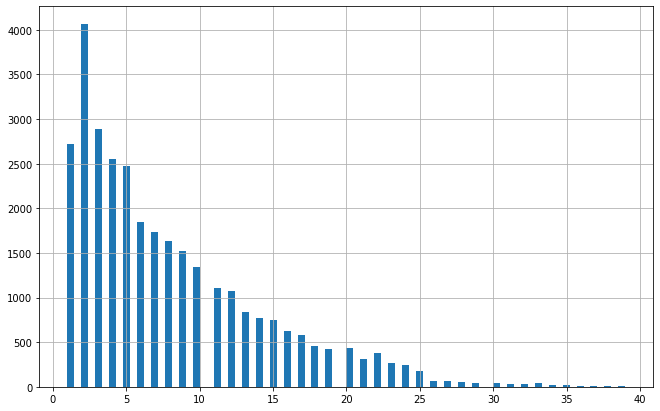

In [268]:
plt.figure(figsize=(11,7))
realty_data[realty_data['floor'] < 40]['floor'].hist(bins=80)

Количество квартир в датасете выставленных на разных этажах. Больше всего продается квартир на втором этаже. Одинаконово много - 2500 - от первого по пятный этаж. Далее от 1750 и ниже представлены квартиры на этажах от 6 и выше.

In [269]:
realty_data[realty_data['floor'] > 30]['floor'].value_counts().sum()

354

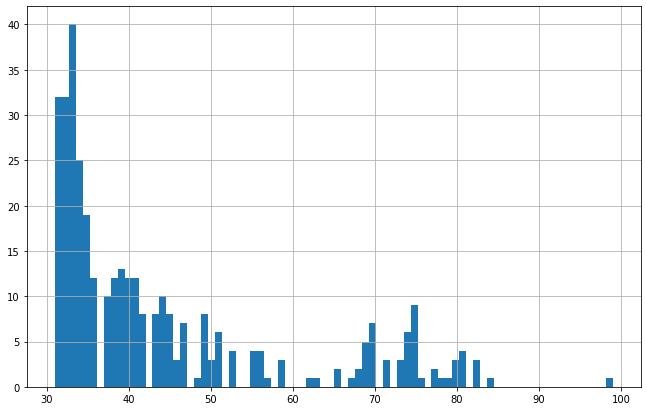

In [270]:
plt.figure(figsize=(11,7))
realty_data[realty_data['floor'] > 30]['floor'].hist(bins=80)

Совсем немного квартир выше 30 этажа - 354 шт. Ниже представленно их распределение. 

### Распределение высотности домов в которых продают квартиры для разных городов

([<matplotlib.axis.XTick at 0x20bd5bc3d88>,
 <a list of 40 Text xticklabel objects>)

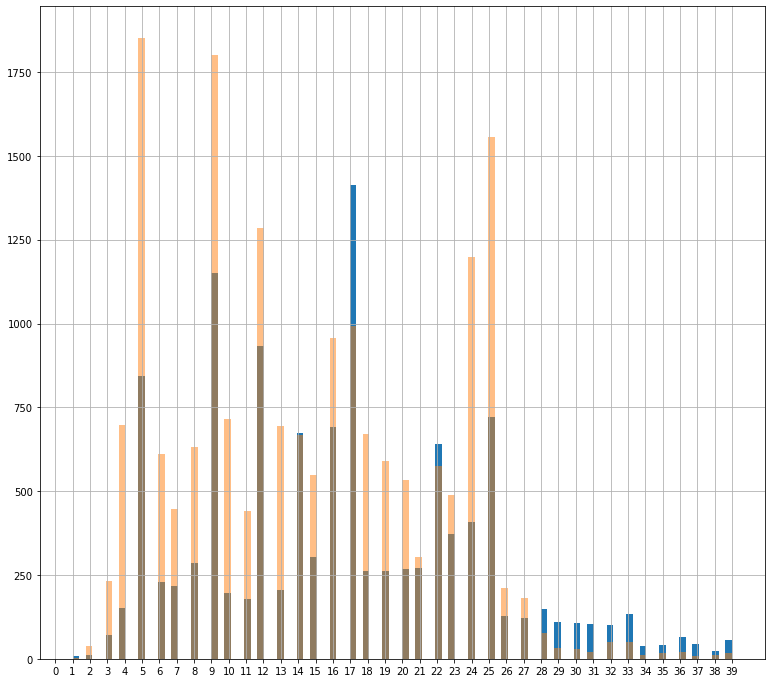

In [271]:
plt.figure(figsize=(13,12))
realty_data[realty_data['storeys'] < 40][realty_data['city'] == 'Москве']['storeys'].hist(bins=100)
realty_data[realty_data['storeys'] < 40][realty_data['city'] == 'Петербурге']['storeys'].hist(bins=100, alpha=0.5)
#plt.grid(False)
plt.xticks(np.arange(0,40,1))

На гистограмме выше представлено число объявлений о продаже квартир в разрезе высотности домов в которых они продаются. Можно увидеть, что как в Москве, так и в Питере большинство домомв не выше 25 этажа. Наиболее распространенная высотность домов 5, 9, 12, 16, 17, 24 и 25. Посокольку данных по Питеру немного больше, соответвенно и предложений будет больше по самым популярным по высотности домам. Однако, можно отметить, что в Москве гораздо больше 17 этажных домов, чем в СПб. Видно так же, что для Москвы, несмотря на меньшее число данных по ней, квартир в домах выше 27 этажа больше. Это может говорить о большей высотности города. 

### Срезаем типы квартир по которым мало наблюдений

In [272]:
list_type = realty_data['type'].value_counts().reset_index()['index'].tolist()
list_type = ['2-к квартира',
 '1-к квартира',
 '3-к квартира',
 'Студия',
 '4-к квартира','5-к квартира']

list_type

['2-к квартира',
 '1-к квартира',
 '3-к квартира',
 'Студия',
 '4-к квартира',
 '5-к квартира']

In [273]:
popular_reaty = realty_data.query('type in @list_type')
popular_reaty['type'].value_counts()

2-к квартира    9260
1-к квартира    8690
3-к квартира    6979
Студия          4562
4-к квартира    1709
5-к квартира     367
Name: type, dtype: int64

### Расрпеделение средних цены для квартир разного размера

Text(0.5, 1.0, 'Realty price')

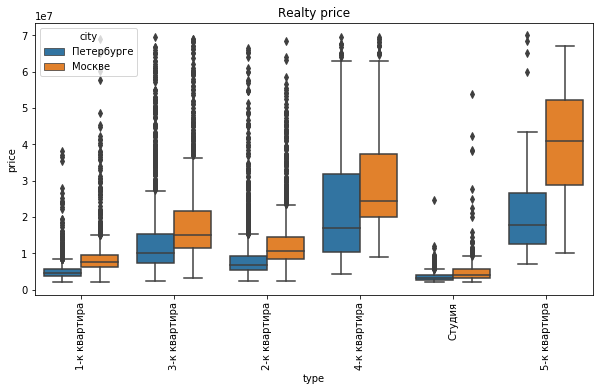

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns

popular_reaty_p = popular_reaty[popular_reaty['price'] < 70000000]
popular_reaty_p = popular_reaty_p[popular_reaty_p['period'] == 1]

plt.figure(figsize=(10,5))
sns.boxplot(y='price', x='type', 
                data=popular_reaty_p, 
                #palette="colorblind",
                #dodge=True,
                hue='city')
plt.xticks(rotation=90)
plt.title('Realty price')

Ящик с усами показывает, как с увеличением размера квартиры растет и цена. Чем больше квартира, тем больше разброс в цене. Квартиры в Москве дороже. 

### Сводная таблица по средней и медианной цене для Мск и СПб для разных типов

In [275]:
popular_reaty.pivot_table(index=['type'], columns=['city','period'], values=['price'], aggfunc=['mean', 'median'])

mean                                            \
                     price                                             
city                Москве                  Петербурге                 
period                 1.0           2.0           1.0           2.0   
type                                                                   
1-к квартира  9.002521e+06  8.628550e+06  5.160164e+06  6.273936e+06   
2-к квартира  1.404218e+07  1.398084e+07  8.999517e+06  1.092764e+07   
3-к квартира  2.015954e+07  2.128656e+07  1.446341e+07  1.890750e+07   
4-к квартира  3.395380e+07  3.242103e+07  2.592318e+07  2.960609e+07   
5-к квартира  5.593019e+07  5.325117e+07  2.831883e+07  3.719192e+07   
Студия        4.926064e+06  4.820824e+06  3.485412e+06  3.761386e+06   

                median                                 
                 price                                 
city            Москве           Петербурге            
period             1.0       2.0        1.0       2.0  
type                                                   
1-к квартира   7500000   7500000    4600000   5200000  
2-к квартира  10773342  10500000    6850000   8281120  
3-к квартира  15375040  15543330    9994000  13000000  
4-к квартира  25293444  25153630   17800000  21950000  
5-к квартира  54000000  55000000   20400000  25780000  
Студия         4071250   4100000    3250000   3400000

### Расрпеделение средних цены за квадратный метр для квартир разного размера

Text(0.5, 1.0, 'Realty price')

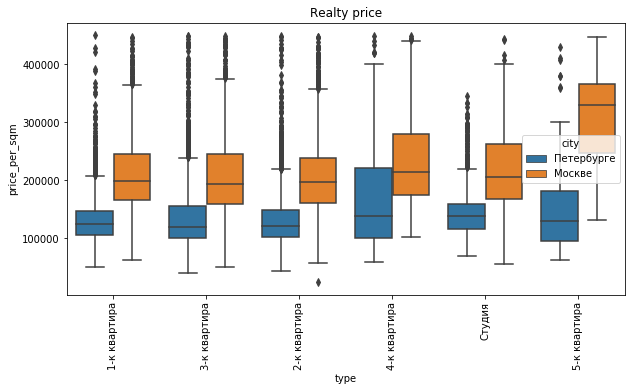

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns

popular_reaty_ppsm = popular_reaty[popular_reaty['price_per_sqm'] < 450000]
popular_reaty_ppsm = popular_reaty_ppsm[popular_reaty_ppsm['period'] == 1]

plt.figure(figsize=(10,5))
sns.boxplot(y='price_per_sqm', x='type', 
                 data=popular_reaty_ppsm, 
                 #palette="colorblind",
                #dodge=True,
                 hue='city')

plt.xticks(rotation=90)
plt.title('Realty price')

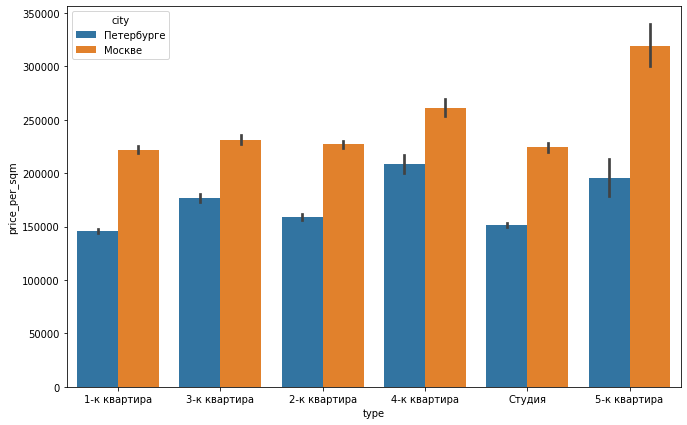

In [277]:
plt.figure(figsize=(11,7))
sns.barplot(x="type", y="price_per_sqm", hue="city", dodge=True,
                     data=popular_reaty)
plt.show()

Как видно цены в Москве выше чем в СПб. Для студий 1, 2 и 3 комнатных квартир цена за кв. м. стоит рядом. Для 4 и 5 цена выше. 

### Цены для разного размера квартиры за квадратный метр за два месяца по каждому городу

Text(0.5, 1.0, 'Realty price')

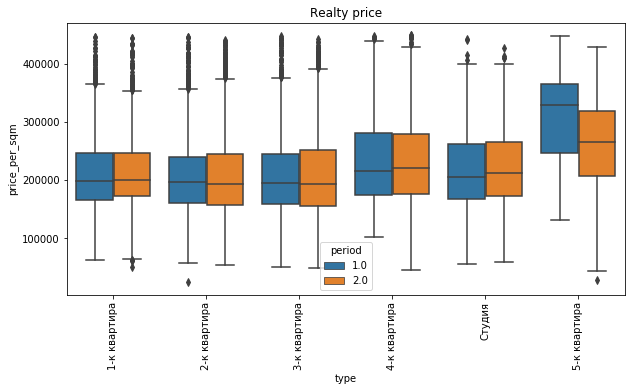

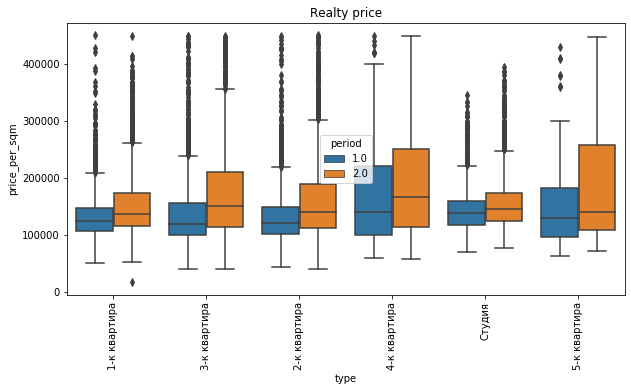

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns

popular_reaty_ppsm = popular_reaty[popular_reaty['price_per_sqm'] < 450000]

plt.figure(figsize=(10,5))
sns.boxplot(y='price_per_sqm', x='type', 
                 data=popular_reaty_ppsm[popular_reaty_ppsm['city']=='Москве'], 
                 #palette="colorblind",
                #dodge=True,
                 hue='period')

plt.xticks(rotation=90)
plt.title('Realty price')

plt.figure(figsize=(10,5))
sns.boxplot(y='price_per_sqm', x='type', 
                 data=popular_reaty_ppsm[popular_reaty_ppsm['city']=='Петербурге'], 
                 #palette="colorblind",
                #dodge=True,
                 hue='period')

plt.xticks(rotation=90)
plt.title('Realty price')

Довольно неожиданный результат. Цены на недвижимость, как правило растут. Данные показывают не просто спад цен для квартир в Москве, но и одновременно рост цен для Питера. 

### Графики соотношения цены за квартиру / цены за кв.м и площади

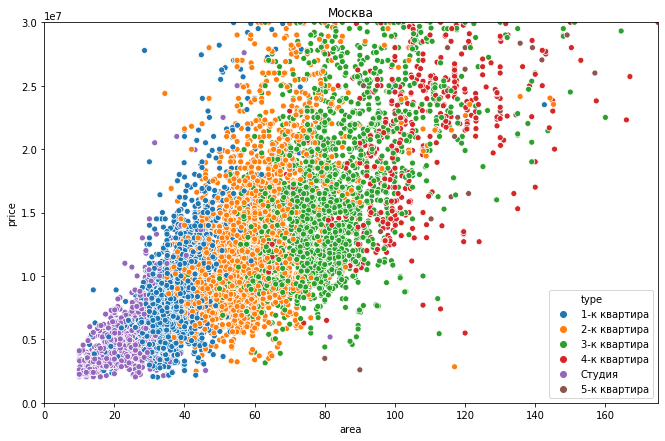

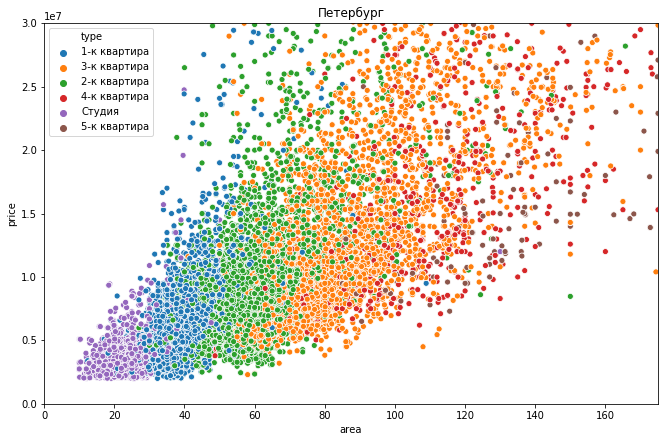

In [279]:
plt.figure(figsize=(11,7))
sns.scatterplot(x="area", y="price", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Москве'])

plt.ylim(0,30000000)
plt.xlim(0,175)
plt.title('Москва')
plt.show()

plt.figure(figsize=(11,7))
sns.scatterplot(x="area", y="price", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Петербурге'])

plt.ylim(0,30000000)
plt.xlim(0,175)
plt.title('Петербург')
plt.show()

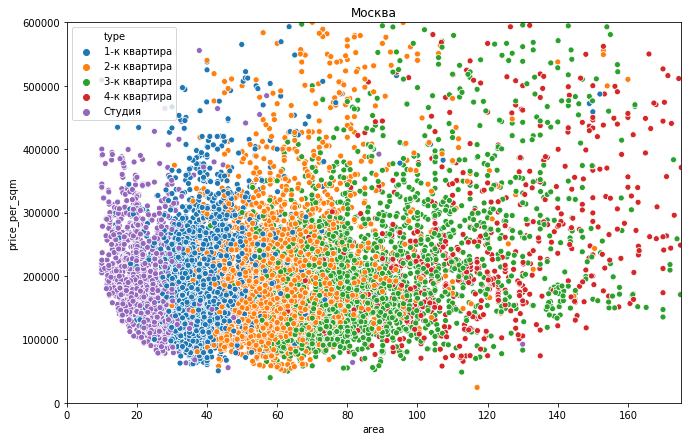

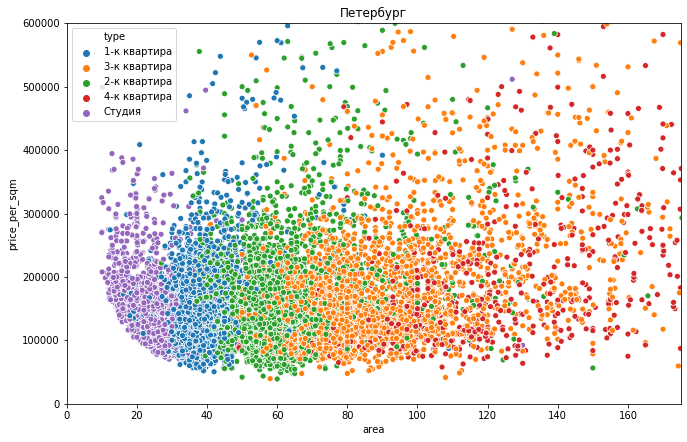

In [118]:
plt.figure(figsize=(11,7))
sns.scatterplot(x="area", y="price_per_sqm", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Москве'])
plt.ylim(0, 600000)
plt.xlim(0,175)
plt.title('Москва')
plt.show()

plt.figure(figsize=(11,7))
sns.scatterplot(x="area", y="price_per_sqm", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Петербурге'])
plt.ylim(0, 600000)
plt.xlim(0,175)
plt.title('Петербург')
plt.show()

In [281]:
print(popular_reaty.corr())

               metro_dist      area     floor   storeys     price  \
metro_dist       1.000000 -0.086764  0.059367  0.082051 -0.202733   
area            -0.086764  1.000000  0.086270  0.063986  0.749630   
floor            0.059367  0.086270  1.000000  0.681103  0.133036   
storeys          0.082051  0.063986  0.681103  1.000000  0.132655   
price           -0.202733  0.749630  0.133036  0.132655  1.000000   
price_per_sqm   -0.306889  0.281079  0.132510  0.143700  0.777521   
new_house        0.089902  0.007465  0.167189  0.229935 -0.005579   
month           -0.016351  0.022937  0.022874  0.015183  0.044592   
period          -0.030461  0.026113  0.028272  0.027599  0.060139   

               price_per_sqm  new_house     month    period  
metro_dist         -0.306889   0.089902 -0.016351 -0.030461  
area                0.281079   0.007465  0.022937  0.026113  
floor               0.132510   0.167189  0.022874  0.028272  
storeys             0.143700   0.229935  0.015183  0.027599  

Очевидна зависимость между ценой за квартиру и площадью и отсутсвие связи между ценой за кв.м и площадью

### Соотношение этажности домов и цен за квадратный метр

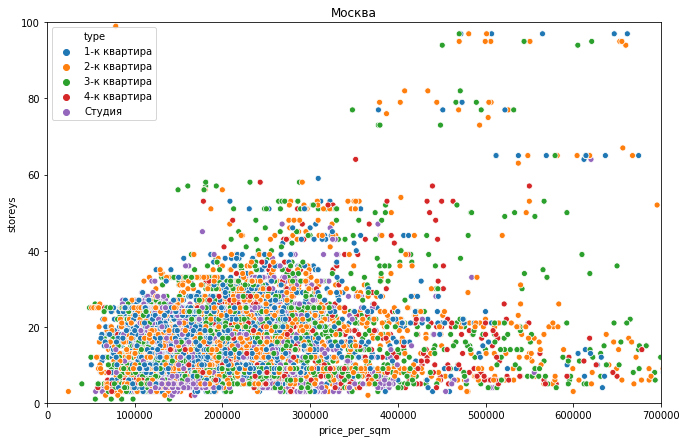

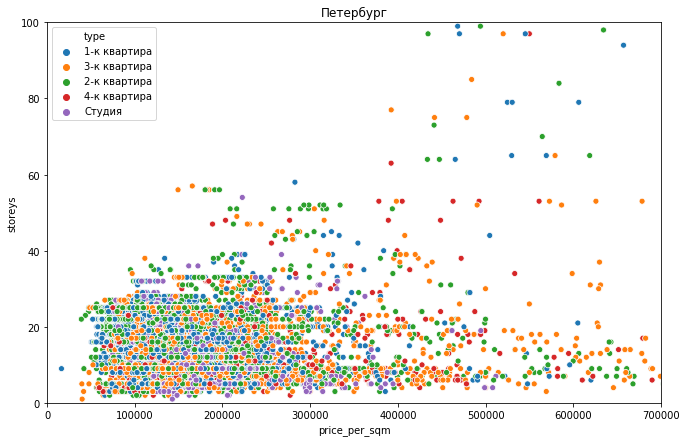

In [123]:
plt.figure(figsize=(11,7))
sns.scatterplot(x="price_per_sqm", y="storeys", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Москве'])
plt.xlim(0, 700000)
plt.ylim(0,100)
plt.title('Москва')
plt.show()

plt.figure(figsize=(11,7))
sns.scatterplot(x="price_per_sqm", y="storeys", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Петербурге'])
plt.xlim(0, 700000)
plt.ylim(0,100)
plt.title('Петербург')
plt.show()

Можно предположить, что на графике для Москвы видны башни "Москва сити" - три линии на уровне 60, 80 и 100 этажа. Единственное высотное здание в Питере - это башня "Лахта центр". В основнов видно, что Питер 35 этажный, а Москва 40 этажная.

### Соотношение площади и этажности

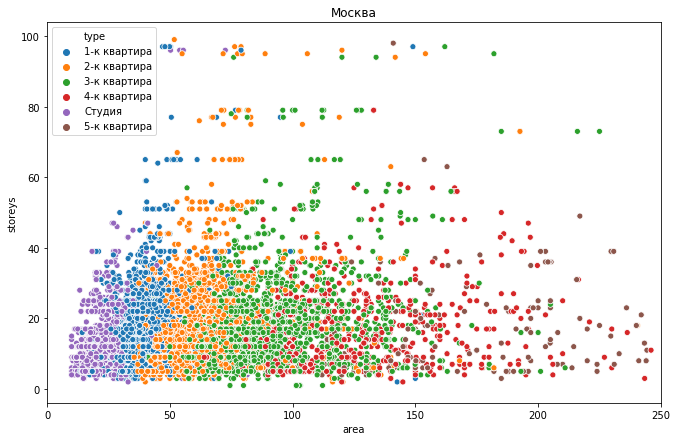

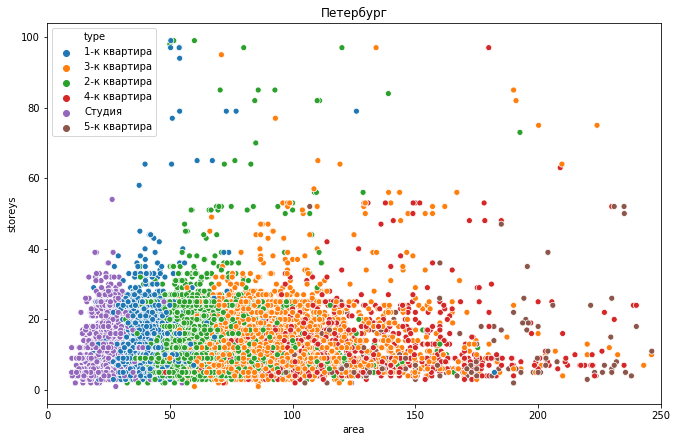

In [292]:
plt.figure(figsize=(11,7))
sns.scatterplot(x="area", y="storeys", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Москве'])
plt.xlim(0,250)
#plt.ylim(0,100)
plt.title('Москва')
plt.show()

plt.figure(figsize=(11,7))
sns.scatterplot(x="area", y="storeys", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Петербурге'])
plt.xlim(0,250)
#plt.ylim(0,100)
plt.title('Петербург')
plt.show()

Здания разной этажности от минимальной до 100 имеют квартиры от минимальной до 250 кв.м.

### Соотношение этажности и дистанции до метро

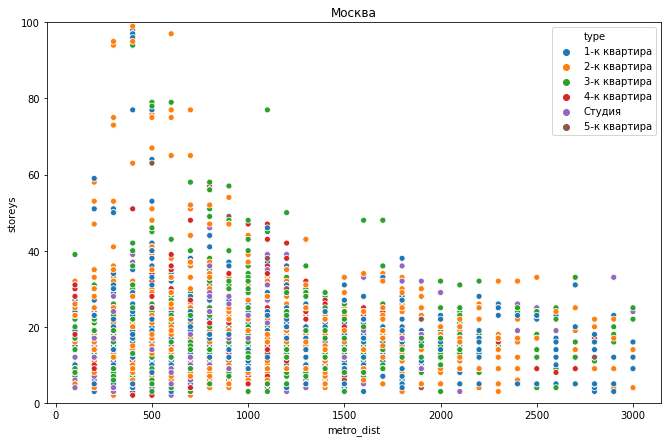

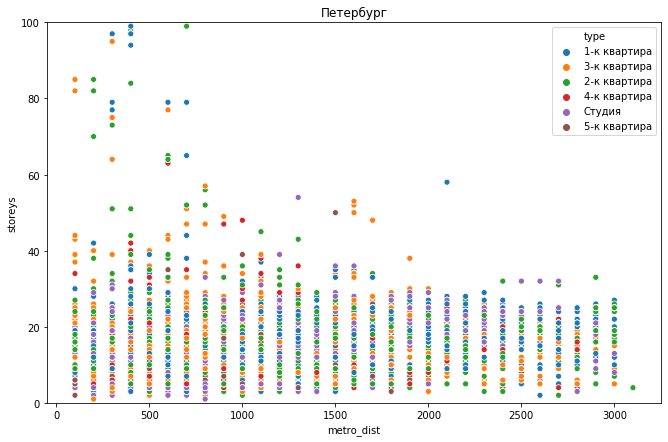

In [296]:
plt.figure(figsize=(11,7))
sns.scatterplot(x="metro_dist", y="storeys", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Москве'])
#plt.xlim(0, 700000)
plt.ylim(0,100)
plt.title('Москва')
plt.show()

plt.figure(figsize=(11,7))
sns.scatterplot(x="metro_dist", y="storeys", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Петербурге'])
#plt.xlim(0, 700000)
plt.ylim(0,100)
plt.title('Петербург')
plt.show()

В целом, большинство квартир распределено равномерно. Но высотные здания строются ближе к метро. Типы квартир распределены равномерно.

### Соотношение цены за кв.м. и дистанции до метро

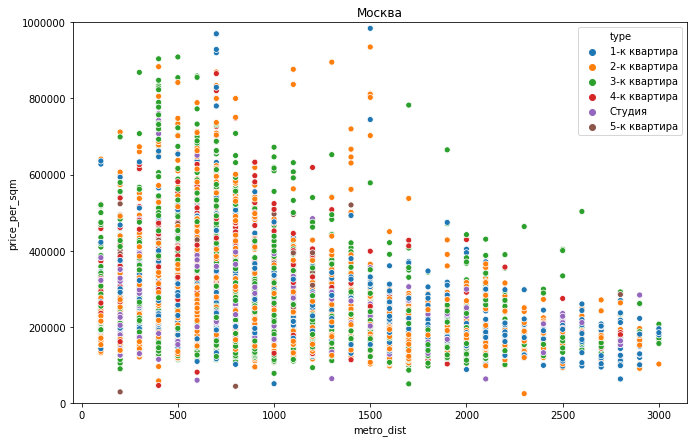

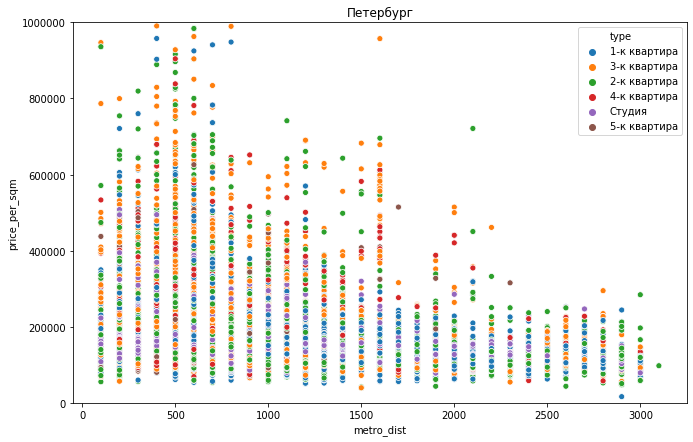

In [300]:
plt.figure(figsize=(11,7))
sns.scatterplot(x="metro_dist", y="price_per_sqm", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Москве'])
plt.ylim(0, 1000000)
#plt.xlim(0,30)
plt.title('Москва')
plt.show()

plt.figure(figsize=(11,7))
sns.scatterplot(x="metro_dist", y="price_per_sqm", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Петербурге'])
plt.ylim(0, 1000000)
#plt.xlim(0,30)
plt.title('Петербург')
plt.show()

Чем ближе квартиры к метро, тем выше и стоимость. 

### Сравнение площади и дистации до метро

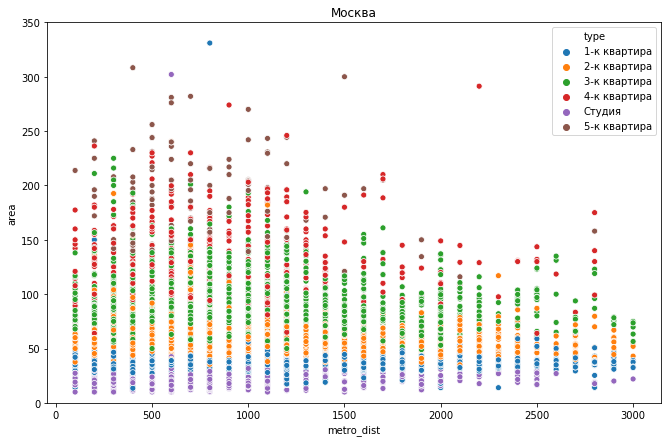

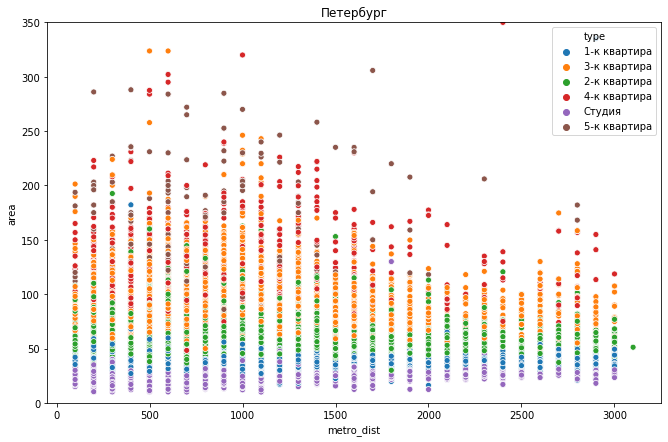

In [303]:
plt.figure(figsize=(11,7))
sns.scatterplot(x="metro_dist", y="area", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Москве'])
#plt.xlim(0, 700000)
plt.ylim(0,350)
plt.title('Москва')
plt.show()

plt.figure(figsize=(11,7))
sns.scatterplot(x="metro_dist", y="area", hue="type",
                     data=popular_reaty[popular_reaty['city']=='Петербурге'])
#plt.xlim(0, 700000)
plt.ylim(0,350)
plt.title('Петербург')
plt.show()

Чем ближе к метро, тем больше квартир с большой площадью

### Изменение средней цены за кв.м. в связи с этажом

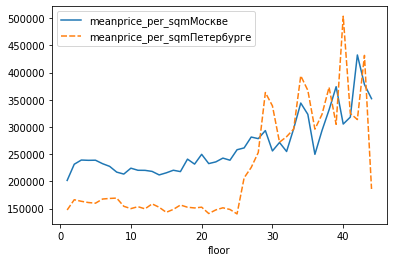

In [307]:
realty_floor = pd.pivot_table(realty_data[realty_data['floor'] < 45], index=['floor'], columns='city', values=['price_per_sqm'], aggfunc=['mean']) \
    #.reset_index()

realty_floor.columns = realty_floor.columns.to_series().str.join('')

sns.lineplot(data=realty_floor)

### Изменение средней цены за кв метр в связи с площадью

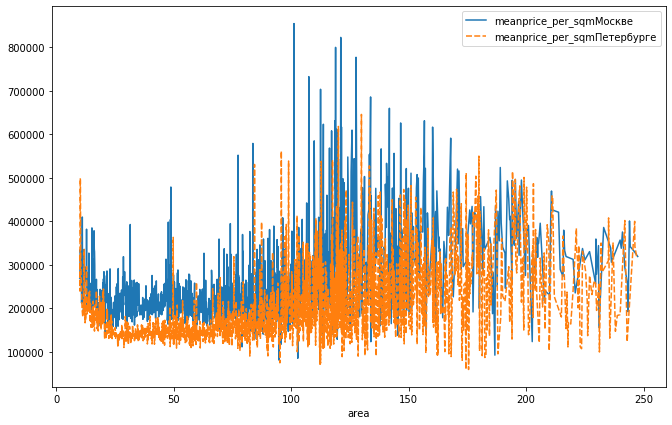

In [308]:
realty_area_price = pd.pivot_table(realty_data[realty_data['area'] < 250], index=['area'], columns='city', values=['price_per_sqm'], aggfunc=['mean']) \
    #.reset_index()

realty_area_price.columns = realty_area_price.columns.to_series().str.join('')

plt.figure(figsize=(11,7))
sns.lineplot(data=realty_area_price)

### Выводы: 
Кварты в Москве дороже чем в Питере. За два месяца квартиры в Москве стали немного дешевле, а в Питере выросли. Цена за кв.м. не зависит от типа квартиры для 1-3-к квартий и струдий, для 4 и 5-к стоимость растет. Питер и Москва различаются по высотности. Москва - выше. Можно увидеть, что как в Москве, так и в Питере большинство домомв не выше 25 этажа. Наиболее распространенная высотность домов 5, 9, 12, 16, 17, 24 и 25. Чем ближе дистанция до метро, тем дороже и выше квартиры. 